In [41]:
import numpy as np
import matplotlib.pyplot as plt
import gym 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from multiprocessing_env import SubprocVecEnv


In [42]:
GAMMA = 0.99
LR = 1e-3
BETA = 0.001
BATCH_SZ = 1
HIDDEN_SZ = 128
AVG = 100
REW_THRESH = 195

In [43]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_ENV = 8
ENV_NAME = "CartPole-v0"
print("Using device:", DEVICE)

env = gym.make(ENV_NAME)

Using device: cuda


In [44]:
class A2C(nn.Module):
    def __init__(self, input_size, n_actions, lr=LR, device=DEVICE):
        super(A2C, self).__init__()
        self.lr = lr
        self.device = device

        self.actor = nn.Sequential( 
            nn.Linear(input_size, HIDDEN_SZ), 
            nn.ReLU(),
            nn.Linear(HIDDEN_SZ, n_actions), 
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(input_size, HIDDEN_SZ),
            nn.ReLU(),
            nn.Linear(HIDDEN_SZ, 1)
        )
        
        self.actor = self.actor.to(self.device)
        self.critic = self.critic.to(self.device)
        
        self.optim = torch.optim.Adam(list(self.actor.parameters()) + list(self.critic.parameters()), lr=self.lr)

    def forward(self, x):
        # value = self.critic(x.cuda() if self.device == 'cuda' else x)
        # probs = self.actor(x.cuda() if self.device == 'cuda' else x)
        probs = self.actor(x)
        value = self.critic(x)
        
        distribution = Categorical(probs)
        return distribution, value

        


In [45]:
def compute_reward(next_v, rewards, masks, gamma=GAMMA):
    R = next_v
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def test_env(agent):
    runs = 10
    mean_rew = 0
    for _ in range(runs):
        state = env.reset()[0]
        done = False
        while not done:
            state = torch.FloatTensor(state).to(DEVICE)
            distr, val = agent.model(state)
            act = distr.sample()
            next_s, rew, done, _, _ = env.step(act.cpu().numpy())
            mean_rew += rew
            state = next_s

    mean_rew /= runs
    return mean_rew

In [46]:
class Agent: 
    def __init__(self, env, model, batch_sz=BATCH_SZ):
        self.env = env
        self.model = model
        self.batch_sz = batch_sz
        self.initialise()
        
    def initialise(self):
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.masks = []
        self.entropy = 0
        
    
    def update_model(self, beta):
        advantage = self.returns - self.values
        actor_loss = -(self.log_probs.to(self.model.device) * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + 0.5 * critic_loss - beta * self.entropy

        self.model.optim.zero_grad()
        loss.backward()
        self.model.optim.step()
        
    def train(self, max_ep, gamma=GAMMA, beta=BETA):
        s = self.env.reset()[0]
        total_rew = []
        ep = 0
        while ep <  max_ep:
            # rollout trajectory?
            for run in range(5):
                s = torch.FloatTensor(s).to(self.model.device)
                dist, v = self.model(s)
                # print(v, type(v))

                a = dist.sample()
                ns, r, done, _, _ = self.env.step(a.cpu().numpy())

                log_prob = dist.log_prob(a)
                # print('after finding log prob: ', log_prob)
                self.entropy += dist.entropy().mean()
                if type(self.log_probs) == list:
                    self.log_probs.append(log_prob.unsqueeze(0))
                else:
                    self.log_probs = torch.cat((self.log_probs, log_prob.unsqueeze(0).to(self.model.device)), dim=0)

                # print('after log probs')
                if type(self.values) == list:
                    self.values.append(v)
                else:
                    self.values.tolist().append(v)
                self.rewards.append(r)
                self.masks.append(1 - done)
                # self.rewards.append(torch.FloatTensor(r).unsqueeze(1).to(self.model.device))
                # self.masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(self.model.device))
                if done: 
                    s = self.env.reset()[0]
                s = ns
                ep += 1

                if ep % AVG == 0:
                    mean_rew = test_env(self)
                    print(f'Episode: {ep}, Mean Reward: {mean_rew}')
            
            ns = torch.FloatTensor(ns).to(self.model.device)
            _, next_v = self.model(ns)
            returns = compute_reward(next_v, self.rewards, self.masks)
            # print('after computing reward')
            # print("log probs: ")
            # print(self.log_probs)
            # print("returns: ")
            # print(self.returns)
            # print("values: ")
            # print(self.values)
            total_rew.append(returns)


            self.log_probs = torch.Tensor(self.log_probs).to(self.model.device)
            self.returns = torch.cat(returns)
            self.values = torch.Tensor(self.values).to(self.model.device)
            # print('hello')
            # print(self.log_probs)
            # print(self.returns)
            # print(self.values)

            self.update_model(beta)
            self.initialise()

                    
        return total_rew

In [47]:
# envs = [gym.make(ENV_NAME) for _ in range(N_ENV)]
# envs = SubprocVecEnv(envs)
envs = gym.make(ENV_NAME)

model = A2C(envs.observation_space.shape[0], envs.action_space.n)
agent = Agent(envs, model)

rewards = agent.train(max_ep=1500, gamma=GAMMA, beta=BETA)

Episode: 100, Mean Reward: 19.3
Episode: 200, Mean Reward: 22.2
Episode: 300, Mean Reward: 19.7
Episode: 400, Mean Reward: 19.8
Episode: 500, Mean Reward: 22.4
Episode: 600, Mean Reward: 18.9
Episode: 700, Mean Reward: 22.1
Episode: 800, Mean Reward: 22.1
Episode: 900, Mean Reward: 31.3
Episode: 1000, Mean Reward: 17.4
Episode: 1100, Mean Reward: 20.3
Episode: 1200, Mean Reward: 16.3
Episode: 1300, Mean Reward: 24.4
Episode: 1400, Mean Reward: 15.2
Episode: 1500, Mean Reward: 23.3


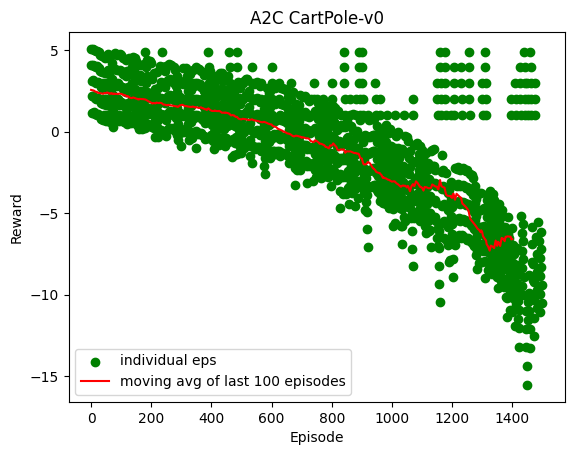

In [48]:
# plotting the rewards
# rewards = rewards.tolist()
rewards = [item.item() for sublist in rewards for item in sublist]
# print(rewards)
cumsum = np.cumsum(np.insert(rewards, 0, 0))
cumsum = (cumsum[AVG:] - cumsum[:-AVG]) / float(AVG)

plt.scatter(np.arange(len(rewards)), rewards, label='individual eps', color='green')
plt.plot(cumsum, label=f'moving avg of last {AVG} episodes', color='red')
plt.title('A2C CartPole-v0')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()